In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 256

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomRotation(degrees=(-45, 45)),
#     transforms.ColorJitter(brightness=.5,hue=0.5), # 改变图像的亮度和饱和度
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, pin_memory=True, num_workers=4)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=False, pin_memory=True, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


# Res2Net

In [3]:
class Bottle2neck(nn.Module):
    expansion = 4
    
    def __init__(self, in_planes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        super(Bottle2neck, self).__init__()
        width = int(math.floor(planes * (baseWidth/64.0)))
        self.conv1 = nn.Conv2d(in_planes, width*scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width*scale)
        
        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride = stride, padding=1)
        
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)
        
        self.conv3 = nn.Conv2d(width*scale, planes*self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)
        
        self.relu = nn.ReLU(True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype=='stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        return out
    
class Res2Net(nn.Module):
    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=100):
        self.in_planes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1, bias=False), 
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride, 
                    ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.in_planes, planes * block.expansion, 
                    kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample=downsample, 
                        stype='stage', baseWidth = self.baseWidth, scale=self.scale))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes, baseWidth = self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def Res2Net26():
    return Res2Net(Bottle2neck, [2, 2, 2, 2], baseWidth=26, scale=4)
    
def Res2Net50():
    return Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4)

In [4]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def adjust_learning_rate(optimizer, current_iter, warmup_iter, max_warm_up_lr):
    if current_iter <= warmup_iter:
        lr = max_warm_up_lr * current_iter / warmup_iter
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [5]:
loss_arr = []
acc_arr = []
lr_arr = []

In [6]:
def fit(model, epochs, train_loader, valid_loader, optimizer, lr_scheduler,
        loss_fn, updata_lr_every_epoch, warm_up=False, max_warm_up_lr=0.01, grad_clip=None, PATH='./CANet/CANet.pth'):
    log_interval = int((50000/batch_size)/2)
    for epoch in range(epochs):
        print(f"{'='*20} Epoch: {epoch+1} {'='*20}\n")
        model.train()
        avg_loss = 0
        
        for i, (inputs, targets) in enumerate(train_loader):
            if warm_up != False and epoch <= warm_up:
                adjust_learning_rate(optimizer, (i+1)+epoch*len(train_loader), len(train_loader)*warm_up, max_warm_up_lr=max_warm_up_lr)
#                 lr_arr.append(get_lr(optimizer))
            outputs = model(inputs.to(device))
            loss = loss_fn(outputs, targets.to(device))
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            if lr_scheduler is not None and updata_lr_every_epoch == False:
                lr_scheduler.step()
                lr_arr.append(get_lr(optimizer))
            optimizer.zero_grad()
            
            avg_loss += loss.item()
            if i % log_interval == log_interval-1:
                avg_loss = avg_loss/log_interval
#                 train_loss_arr.append(avg_loss)
                print(f"batch: {i+1}, train_loss: {avg_loss:.4f}")
#                 print(f"batch: {i+1}, train_loss: {avg_loss:.4f}, last_lr: {lr_arr[-1]:.5f}")
                avg_loss = 0

        if lr_scheduler is not None and updata_lr_every_epoch == True:
            lr_scheduler.step()
            lr_arr.append(get_lr(optimizer))
        if lr_scheduler is None:
            lr_arr.append(get_lr(optimizer))
        
        model.eval()
        correct = 0
        total = 0
        avg_loss = 0
        with torch.no_grad():
            for (images, labels) in valid_loader:
                outputs = model(images.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.to(device)).sum().item()
                avg_loss += loss_fn(outputs, labels.to(device))
            avg_loss = avg_loss.cpu() / len(valid_loader)
            loss_arr.append(avg_loss)
            acc = 100 * correct / total
            acc_arr.append(acc)
            
        print(f'Accuracy: {acc}% ({correct} / {total}), Loss: {avg_loss:.3f}, Last_lr: {lr_arr[-1]:.5f}')
    torch.save(model, PATH)

In [7]:
model = Res2Net50().to(device)
num_param = sum([param.nelement() for param in model.parameters()])
print("Number of parameter: %.2fM" % (num_param/1e6))

TypeError: Value after * must be an iterable, not int

In [12]:
%%time

epochs = 10
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# sched = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.2)
# sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
#                                       steps_per_epoch=len(trainloader))

loaded_model = Res2Net50().to(device)
loaded_model.load_state_dict(torch.load('./Res2Net/Res2Net_10.pth'))
                             
fit(model=loaded_model,
    epochs=epochs,
    train_loader=trainloader,
    valid_loader=testloader,
    optimizer=optimizer,
    lr_scheduler=None,
    loss_fn=nn.CrossEntropyLoss(),
    warm_up=False, max_warm_up_lr=0.01,
    grad_clip=None, updata_lr_every_epoch=False, PATH='./Res2Net/Res2Net_20.pth')

==================== Epoch: 1 ====================

batch: 97, train_loss: 2.7275
batch: 194, train_loss: 2.7455
Accuracy: 28.28% (2828 / 10000), Loss: 2.885, Last_lr: 0.01000
==================== Epoch: 2 ====================

batch: 97, train_loss: 2.7408
batch: 194, train_loss: 2.7395
Accuracy: 28.47% (2847 / 10000), Loss: 2.880, Last_lr: 0.01000
==================== Epoch: 3 ====================

batch: 97, train_loss: 2.7487
batch: 194, train_loss: 2.7178
Accuracy: 28.28% (2828 / 10000), Loss: 2.858, Last_lr: 0.01000
==================== Epoch: 4 ====================

batch: 97, train_loss: 2.7407
batch: 194, train_loss: 2.7380
Accuracy: 27.76% (2776 / 10000), Loss: 2.890, Last_lr: 0.01000
==================== Epoch: 5 ====================

batch: 97, train_loss: 2.7461
batch: 194, train_loss: 2.7248
Accuracy: 28.78% (2878 / 10000), Loss: 2.846, Last_lr: 0.01000
==================== Epoch: 6 ====================

batch: 97, train_loss: 2.7334
batch: 194, train_loss: 2.7377
Accurac

KeyboardInterrupt: 

In [9]:
# loss_arr = loss_arr[0:10]
# acc_arr = acc_arr[0:10]
# lr_arr = lr_arr[0:10]

Text(0.5, 1.0, 'LR')

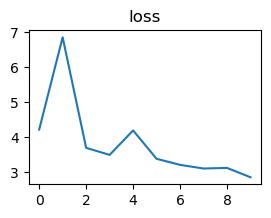

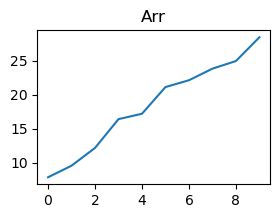

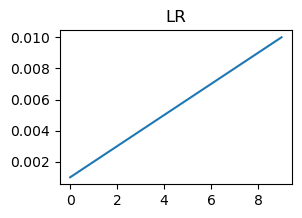

In [10]:
plt.figure(figsize=(3, 2))
plt.plot(loss_arr)
plt.title('loss')

plt.figure(figsize=(3, 2))
plt.plot(acc_arr)
plt.title('Arr')

plt.figure(figsize=(3, 2))
plt.plot(lr_arr)
plt.title('LR')